# Project 1: AirBnB vs Housing Sales
#### Members: Niraj Khatri, Josh Mill, Grace Arhin, Clay Bazzle, Ting Jennings

# Clean The Data

In [1]:
# Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import calendar
import scipy.stats as st

#CLEAN THE AIRBNB DATA
AirBnB_df = pd.read_csv('Resources/AB_US_2020.csv')

#Add date column that states month-year to match city sales df headers
last_review = AirBnB_df.loc[:,'last_review']
AirBnB_df['last_review'] = AirBnB_df['last_review'].fillna('00/00/00')

new_dates_list = []
for date in last_review:
    if int(date[:2]) == 0:
        new_date = '2019DONOTINCLUDE'
        new_dates_list.append(new_date)
        
    elif int(date[:2]) > 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[1]}'
        new_dates_list.append(new_date)
        
    elif int(date[:2]) <= 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[0]}'
        new_dates_list.append(new_date)

AirBnB_df['Month/Year'] = new_dates_list

#Change New York City to New York
AirBnB_df = AirBnB_df.replace("New York City","New York")

#Change NaN for review_per_month to 0
AirBnB_df['reviews_per_month'] = AirBnB_df['reviews_per_month'].fillna(0)


# SALES CITY DATA
#Pull in Sales City data
sales_city_df = pd.read_csv('Resources/House_Sales_City.csv')

#Group Sales City Data and check duplicate cities (will have counts > 1)
grouped_df = sales_city_df.groupby('RegionName').count()

#Pull rows where values = 1 to get non-duplicate cities
sales_city_list = grouped_df[grouped_df['RegionID']==1].index

#Unique cities in the AirBnB data
thelist = AirBnB_df['city'].unique()

#Pull sales city data from cities in AirBnB data
clean_city_df = sales_city_df[sales_city_df['RegionName'].isin(sales_city_list)]
clean_city_df = clean_city_df[clean_city_df['RegionName'].isin(thelist)]

merged_data = AirBnB_df.merge(clean_city_df, right_on = 'RegionName', left_on = 'city')


C:\Users\niraj\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#Create DataFrame of number of AirBnBs in each city
the_df = merged_data.groupby('city').agg({'id': ['count'],'Month/Year':['min']})

#Changes column headers to one level. Do not run more than once in kernel otherwise run previous set of code again followed by this code
the_df.columns.map('_'.join)
the_df.columns=the_df.columns.map('_'.join)

In [27]:
the_df

,id_count,Month/Year_min,Percent Change
city,,,
Asheville,2074,2015-01,47.85%
Boston,3339,2014-09,51.36%
Chicago,6397,2013-08,31.30%
Jersey City,2488,2014-06,48.00%
Los Angeles,31536,2010-03,110.82%
New Orleans,6408,2013-03,60.06%
New York,45756,2011-08,20.71%
Pacific Grove,179,2016-01,19.07%
San Diego,12404,2012-05,78.80%


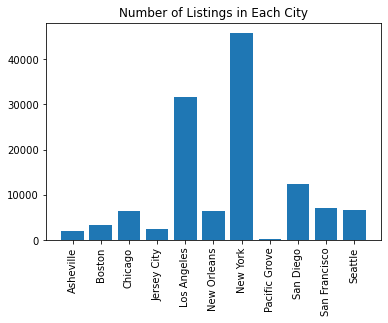

In [36]:
the_df.head(11)

#Create bar graph of cities and their count of listings
x = the_df.index
height = the_df.loc[:,'id_count']
plt.bar(x,height)
plt.xticks(rotation='vertical')
plt.title('Number of Listings in Each City')
plt.savefig('NK_ListingsPerCity.png',bbox_inches='tight')
plt.show()

In [5]:
#Create 2 lists. One for minimum price and the other for the month/year of the minimum price
min_price_list = []
min_year_list = []

#Create 2 lists. One for maximum price and the other for the month/year of the maximum price (which will always be 2020-02)
max_year_list = []
max_price_list = []

#List of all 11 cities
the_df_index = the_df.index

for city in the_df_index:
    city_MY = the_df.loc[city,'Month/Year_min']
    
    
    #FIND MINIMUM SALES PRICE VALUES
    min_value_df = clean_city_df.loc[clean_city_df['RegionName']==city,city_MY]
    min_value = min_value_df.tolist()[0]      

    #List of row indexes
    idx = clean_city_df.index
    idx_list = clean_city_df.index.tolist()

    #List of column indexes
    column_idx = clean_city_df.columns

    #Find row index
    city_idx = idx[clean_city_df['RegionName'] == city].tolist()[0]
    row_idx = idx_list.index(city_idx)

    #Find column index
    MY_idx = column_idx.get_loc(city_MY)

    #Iterate through data set to find first value that is not "nan"
    while np.isnan(min_value):

        min_value = clean_city_df.iloc[row_idx, MY_idx + 1 ]
        MY_idx = MY_idx + 1
    
    #Index into dataframe to collect the minimum sales price.
    minimum_MY = clean_city_df.columns[MY_idx]
    
    #Append price and year to respective lists
    min_price_list.append(min_value)
    min_year_list.append(minimum_MY)  
    
    
    
    #FIND MAXIMUM SALES PRICE VALUES
    max_value_df = clean_city_df.loc[clean_city_df['RegionName']==city,'2020-02'].tolist()[0]
    max_price_list.append(max_value_df)
    max_year_list.append('2020-02')

#Create list of number of listings for each city of AirBnBs
id_count = the_df.loc[:,'id_count'].tolist()       


In [20]:
#Calculate % increase from min MY to max MY

percent_chg_list = []

for city_index in range(0,len(the_df_index)):
    
    percent_change = 100*((max_price_list[city_index] - min_price_list[city_index])/ min_price_list[city_index])
    percent_chg_list.append(percent_change)
    
    #Change min and max month/year to printable format
    month = int(min_year_list[city_index][5:])
    month_name = calendar.month_name[month]
    
    year= min_year_list[city_index][:4]
    
    #Print analysis of each city
    print(f'The city of {the_df_index[city_index]} had {id_count[city_index]:,} listings between {month_name} {year} and February 2020.') 
    print(f'During this period, the housing prices increased by {percent_change:.2f}%')
    print('\n')


percent_str = []
for percent in percent_chg_list:
    string = f'{percent:.2f}%'
    percent_str.append(string)


the_df['Percent Change'] = percent_str
the_df

The city of Asheville had 2,074 listings between January 2015 and February 2020.
During this period, the housing prices increased by 47.85%


The city of Boston had 3,339 listings between September 2014 and February 2020.
During this period, the housing prices increased by 51.36%


The city of Chicago had 6,397 listings between August 2013 and February 2020.
During this period, the housing prices increased by 31.30%


The city of Jersey City had 2,488 listings between August 2016 and February 2020.
During this period, the housing prices increased by 48.00%


The city of Los Angeles had 31,536 listings between March 2010 and February 2020.
During this period, the housing prices increased by 110.82%


The city of New Orleans had 6,408 listings between March 2013 and February 2020.
During this period, the housing prices increased by 60.06%


The city of New York had 45,756 listings between August 2011 and February 2020.
During this period, the housing prices increased by 20.71%


The city

,id_count,Month/Year_min,Percent Change
city,,,
Asheville,2074,2015-01,47.85%
Boston,3339,2014-09,51.36%
Chicago,6397,2013-08,31.30%
Jersey City,2488,2014-06,48.00%
Los Angeles,31536,2010-03,110.82%
New Orleans,6408,2013-03,60.06%
New York,45756,2011-08,20.71%
Pacific Grove,179,2016-01,19.07%
San Diego,12404,2012-05,78.80%


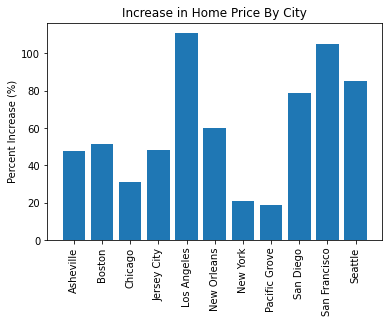

In [79]:
#Plot bar chart of % Change
plt.bar(x,percent_chg_list)
plt.xticks(rotation='vertical')
plt.title('Increase in Home Price By City')
plt.ylabel("Percent Increase (%)")
plt.savefig('NK_PercentChangePerCity.png',bbox_inches='tight')
plt.show()

The correlation between both factors is 0.06


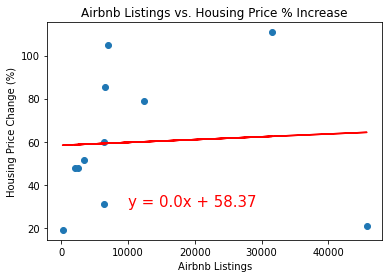

From the given data, it appears that the Airbnb listing count has little to no effect on the change in housing prices over multiple years


In [21]:
#Generate scatter plot of # of AirBnBs vs 2020-2 House Value

x_values = the_df.loc[:,'id_count'].tolist()
y_values = percent_chg_list

#Correlation
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

#Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
#Have to use series instead of list hence 'the_df.loc[:,'id_count']' instead of x_values
regress_values = the_df.loc[:,'id_count'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.title("Airbnb Listings vs. Housing Price % Increase")
plt.xlabel("Airbnb Listings")
plt.ylabel("Housing Price Change (%)")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10000,30),fontsize=15,color="red")
plt.savefig('NK_ScatterPlot.png')
plt.show()

print('From the given data, it appears that the Airbnb listing count has little to no effect on the change in housing prices over multiple years')